# Example 2: Fault properties from extracted network
This example describes how to calculat the strike and length of faults in a network

Now we can load the python packages:

In [1]:
import math
import numpy as np 
import networkx as nx
import pickle
import matplotlib.pyplot as plt


from fatbox.metrics import compute_edge_values
from fatbox.plots import plot_components, plot_edge_attribute, plot_rose
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})

## Load fault network

First, we load a fault network extracted from an oblique rift model:

In [17]:
#G = pickle.load(open('g_27.p', 'rb'))
G = pickle.load(open('/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/test.p', 'rb'))

In [14]:
for keys in G:
    print(keys, '=>', G[keys])

0 => {1: {'length': 1.0}}
1 => {0: {'length': 1.0}}
2 => {3: {'length': 1.0}}
3 => {2: {'length': 1.0}, 4: {'length': 1.0}}
4 => {3: {'length': 1.0}}
5 => {}
8 => {10: {'length': 5.385164807134504}}
10 => {8: {'length': 5.385164807134504}, 17: {'length': 7.211102550927978}}
17 => {10: {'length': 7.211102550927978}}
18 => {}
19 => {}
20 => {31: {'length': 11.704699910719626}}
31 => {39: {'length': 8.94427190999916}, 20: {'length': 11.704699910719626}}
39 => {47: {'length': 1.4142135623730951}, 48: {'length': 1.0}, 49: {'length': 1.4142135623730951}, 31: {'length': 8.94427190999916}}
47 => {39: {'length': 1.4142135623730951}, 48: {'length': 1.0}, 51: {'length': 9.055385138137417}}
48 => {39: {'length': 1.0}, 47: {'length': 1.0}, 49: {'length': 1.0}}
49 => {39: {'length': 1.4142135623730951}, 48: {'length': 1.0}, 53: {'length': 2.23606797749979}}
51 => {54: {'length': 2.23606797749979}, 47: {'length': 9.055385138137417}}
53 => {49: {'length': 2.23606797749979}, 56: {'length': 1.4142135623

Now we can visualize the faults and look at the orientations:

In [16]:
G.nodes[57]

{'pos': (72, 47), 'component': 6, 'strain_rate': 4.2322e-15}

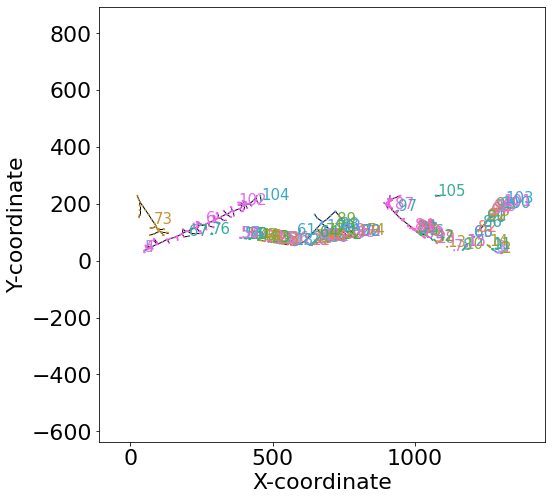

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
#plot_components(G, ax, label=True)
plot_components(G, ax = ax, node_size =1)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()

We can see that most faults are striking N-S and a few E-W. Let's calculate the strike of the edges of the network:

In [18]:
for edge in G.edges:
  x1 = G.nodes[edge[0]]['pos'][0]
  x2 = G.nodes[edge[1]]['pos'][0]
  y1 = G.nodes[edge[0]]['pos'][1]
  y2 = G.nodes[edge[1]]['pos'][1]

  if (x2-x1)<0:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1))) + 360
  else:
    strike = math.degrees(math.atan2((x2-x1),(y2-y1)))
  
  #Scale to [0, 180]
  if strike<=180:
    G.edges[edge]['strike'] = strike
  else:
    G.edges[edge]['strike'] = strike - 180

Let's plot these strikes as edge attributes using this function:

In [19]:
def plot_edge_attribute(G, attribute, ax=[]):
    
    if ax==[]:
        fig, ax = plt.subplots() 

    nx.draw(G,
            pos = nx.get_node_attributes(G, 'pos'),
            node_size = 0.001,
            ax=ax)

    nx.draw_networkx_edges(G,
                           pos = nx.get_node_attributes(G, 'pos'),
                           edge_color = np.array([G.edges[edge][attribute] for edge in G.edges]),
                           edge_cmap=plt.cm.twilight_shifted,
                           ax=ax)
    ax.axis('equal')

    # Colorbar
    cmap = plt.cm.twilight_shifted
    vmax = compute_edge_values(G, attribute, 'max')
    vmin = compute_edge_values(G, attribute, 'min')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
            
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel(attribute, rotation=270)

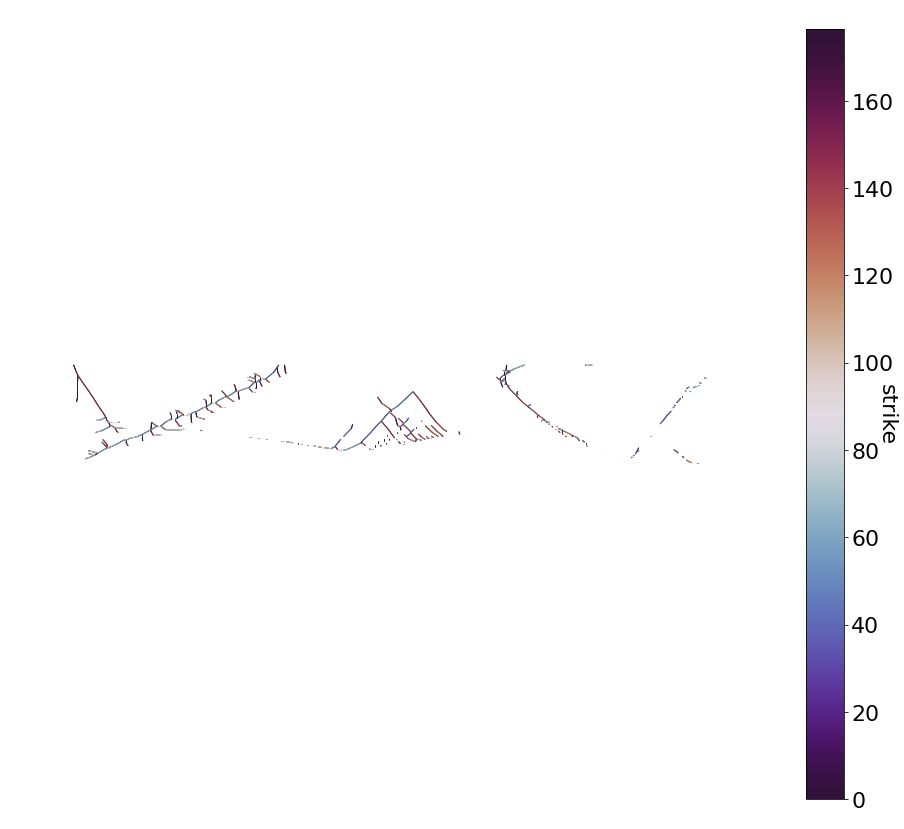

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)

Looks a bit odd, let's zoom in:

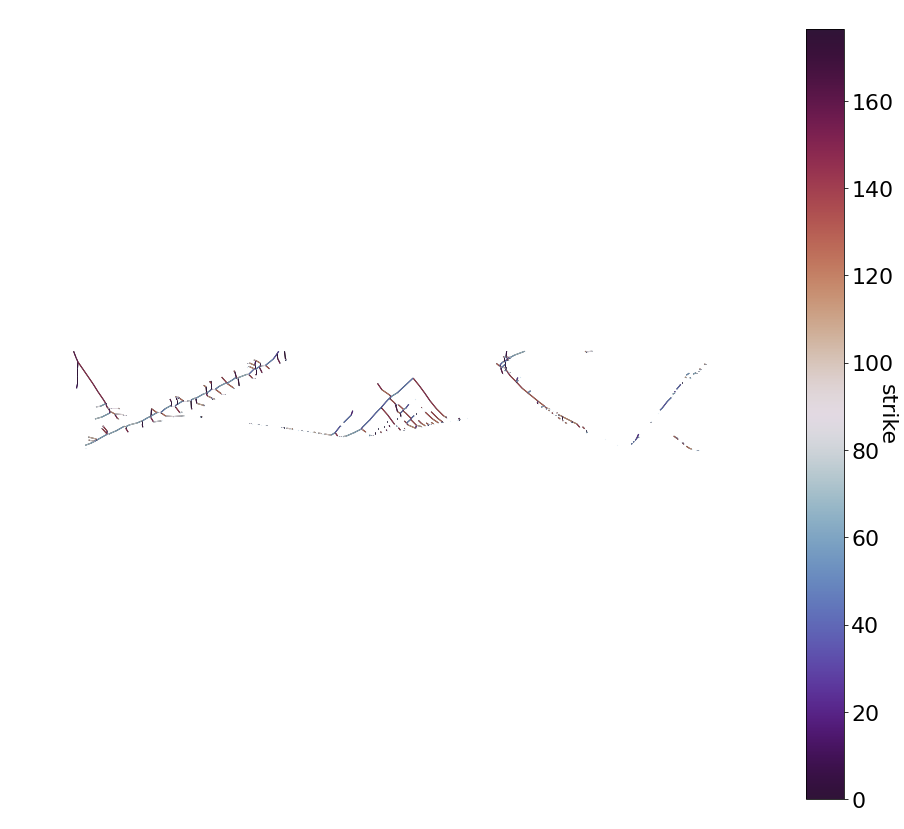

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
plot_edge_attribute(G, 'strike', ax)
ax.set_ylim([50, 150])
plt.show()

Okay, the edges have very discrete strikes (0, 45, 90 degrees), because they were extracted from a regular array. This becomes even more evident when we plot the Rose diagram (a polar histogram of the strikes):

In [22]:
def plot_rose(strikes, lengths=[], ax=[]):    
    
    if lengths ==[]:
        lengths = np.ones_like(np.array(strikes))

    bin_edges = np.arange(-5, 366, 10)
    number_of_strikes, bin_edges = np.histogram(strikes, bin_edges, weights = lengths)           
    number_of_strikes[0] += number_of_strikes[-1]
    half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
    two_halves = np.concatenate([half, half])
    
    cmap = plt.cm.twilight_shifted(np.concatenate((np.linspace(0, 1, 18), np.linspace(0, 1, 18)), axis=0))
     
    if ax==[]:
        fig = plt.figure(figsize=(8,8))
            
        ax = fig.add_subplot(111, projection='polar')
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
    
    ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
           width=np.deg2rad(10), bottom=0.0, color=cmap, edgecolor='k')
    
    #    ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
    ax.set_title('Rose Diagram', y=1.10, fontsize=15)
    
    # fig.tight_layout()


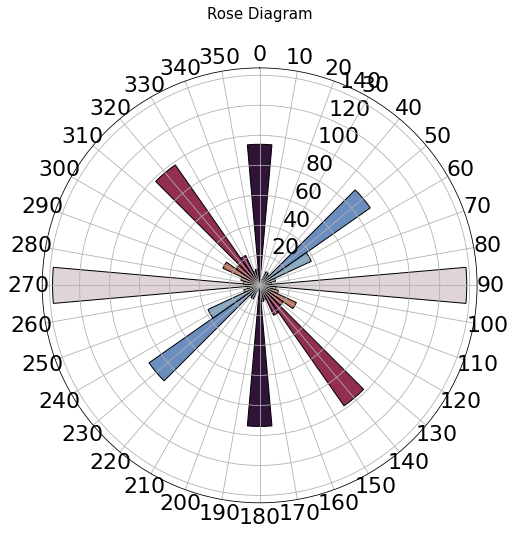

In [23]:
strikes = [G.edges[edge]['strike'] for edge in G.edges]
plot_rose(strikes)

Okay, that's not really what we want. We want the strikes of the faults, not the edges. So let's calculate those:

In [26]:
strikes = []
for cc in nx.connected_components(G):
    edges = G.edges(cc)
    edge_strikes = []
    for edge in edges:
        edge_strikes.append(G.edges[edge]['strike'])
        strikes.append(np.mean(edge_strikes))

and the fault lenghts as weights:

In [27]:
for edge in G.edges:
    G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

In [30]:
lengths = []
for cc in nx.connected_components(G):
    edges = G.edges(cc)
    edge_lengths = []
    for edge in edges:
        edge_lengths.append(G.edges[edge]['length'])
        lengths.append(np.mean(edge_lengths))

Now we can plot the Rose diagram again:

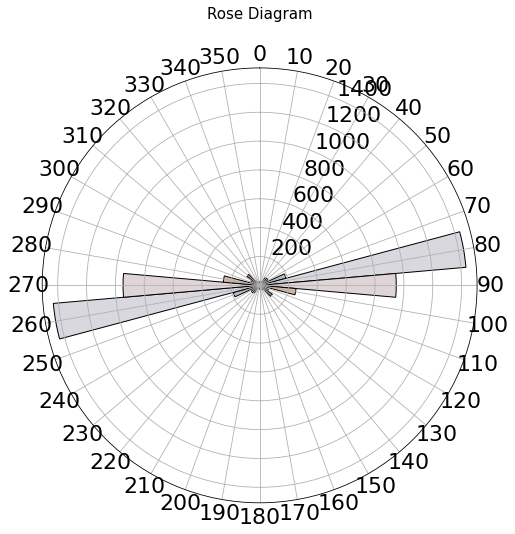

In [31]:
plot_rose(strikes, lengths)

That's a much better representation of the fault strikes in our network!

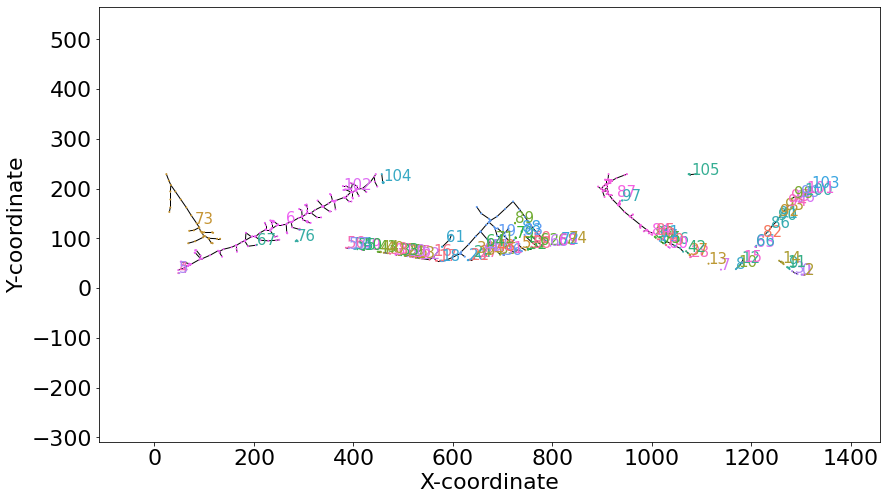

In [35]:
fig, ax = plt.subplots(figsize=(14,8))
plot_components(G, ax = ax, node_size = 1)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()